# Sound Classification using Deep Learning

## 1. Introduction
* The following will demonstrate how to apply Deep Learning techniques to the classification of environmental sounds, specifically focusing on the identification of particular urban sounds.
* When given an audio sample in a computer readable format (such as a .wav file) of a few seconds duration, we need to determine if it contains one of the target urban sounds with a corresponding Classification Accuracy score.

### 2. Dataset
* For this we will use a dataset called Urbansound8K. The dataset contains 8732 sound excerpts (<=4s) of urban sounds from 10 classes, which are:
    * Air Conditioner
    * Car Horn
    * Children Playing
    * Dog bark
    * Drilling
    * Engine Idling
    * Gun Shot
    * Jackhammer
    * Siren
    * Street Music

### 3. Data Preprocessing
* Each audio file in the dataset will be used to extract an MFCC (meaning we have an image representation for each audio sample) and store it in a Panda Dataframe along with it’s classification label. 
* For this we will use Librosa’s mfcc() function which generates an MFCC from time series audio data.

In [ ]:
import numpy as np
import librosa

def extract_features(file_name):
    try:
        #res_type -> resample type
        #n_mfcc -> extracting features
        #axis = 0 -> row wise
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)      
    except Exception as e:
        print("Error encountered while parsing file: ", file)
        return None 
    return mfccsscaled
    
# Load various imports 
import pandas as pd
import os
import librosa

# Set the path to full UrbanSound dataset 
fulldatasetpath = 'full_path_to/UrbanSound8K/audio/'
metadata = pd.read_csv(fulldatasetpath + 'metadata/UrbanSound8K.csv')

features = []

# Iterate through each sound file and extract the features 
for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath(fulldatasetpath),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    class_label = row["classID"]
    data = extract_features(file_name)
    features.append([data, class_label])

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

print('Finished feature extraction from ', len(featuresdf), ' files')

> The above code is used for data loading <br>
> Each audio(.wav) file is converted to pandas dataframe using mfcc and mapped to respective class_label

In [3]:
#To display first three rows (as example)
featuresdf.head(3)

,feature,class_label
0,"[-215.793, 71.66612, -131.81377, -52.09133, -2...",3
1,"[-424.68686, 110.562294, -54.14824, 62.01074, ...",2
2,"[-459.56473, 122.80033, -47.924713, 53.265697,...",2


> As we can observe that the audio files are converted a series of numerical data and mapped to respective labels and stored in a dataframe

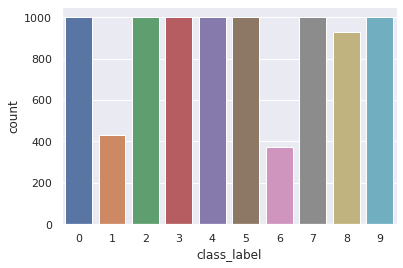

7    1000
5    1000
4    1000
3    1000
2    1000
9    1000
0    1000
8     929
1     429
6     374
Name: class_label, dtype: int64


In [4]:
#To show how many audio files for the respective class with a bar plot representation along with count
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")
ax = sns.countplot(x=featuresdf['class_label'], data = featuresdf)
plt.show()

print(featuresdf['class_label'].value_counts())

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y)) 

# split the dataset 
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.20, random_state = 42)

Using TensorFlow backend.


> 80-20 Train Test split of Data for that we have used Scikit learn train_test_split

In [6]:
#total number of dataset available
print(featuresdf['class_label'].shape)

#Display the number of row and number of column for the below shapes of X and Y
#X
print(x_train.shape)
print(x_test.shape)

#Y
print(y_train.shape)
print(y_test.shape)

(8732,)
(6985, 40)
(1747, 40)
(6985, 10)
(1747, 10)


In [7]:
#example for first row of Y Train as target variable (like One-Hot Encoding)
print(y_train[0])

#example for first row of X Train as Feature variable
print(x_train[0])

array([-8.89295654e+01,  1.17308945e+02, -9.83756409e+01, -7.98500586e+00,
       -3.02204723e+01,  1.68749981e+01,  1.71548309e+01,  3.09231224e+01,
       -1.71333466e+01,  2.00548248e+01, -2.74858284e+00,  7.96005678e+00,
       -9.57434750e+00, -1.44931259e+01,  1.03712463e+00,  1.80540237e+01,
        1.84225464e+00,  1.44545555e+01, -5.32240629e+00,  7.84389162e+00,
       -5.15528619e-01, -4.21097898e+00, -2.51499391e+00,  2.17578435e+00,
        2.18523932e+00,  6.41926432e+00, -4.31260079e-01,  2.79778570e-01,
        2.71853781e+00,  3.60929757e-01,  3.54210883e-01, -3.53838682e+00,
        1.47081196e+00,  2.81663585e+00,  2.55088240e-01, -9.59454775e-02,
       -3.50653887e-01,  2.18912864e+00,  5.62749243e+00, -3.90323305e+00],
      dtype=float32)

> How data in each train and test set is represented here.

In [15]:
#Model -> 1
#Construct Sequential model
#removed Max Pooling and hence Accuracy reduced by 0.20 approx (Not much of difference)
#used Dropout=0.2 initially but achieved accuracy around 59% Hence, when tried with 0.5, it worked better
#filter size starts from 16 and then after it was increased with multiple of 2 for its consecutive layers
#kernel size with 1 was deviating too much while training
#batch size = 52

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

#converting 40 features extracted from MFCC for each audio to represent in 2D Matrix (10*4=40)
num_rows = 10
n_columns = 4

#Mono-Channel
num_channels = 1

#reshaping the numpy array (2D Matrix) to 10 * 4 * 1 from 8732 * 40
x_train = x_train.reshape(x_train.shape[0], num_rows,n_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows,n_columns, num_channels)

#reshaping label/target variable to column wise
num_labels = yy.shape[1]

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows,n_columns, num_channels), activation='relu'))
#model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
#model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
#model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=1, activation='relu'))
#model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 9, 3, 16)          80        
_________________________________________________________________
dropout_15 (Dropout)         (None, 9, 3, 16)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 2, 32)          2080      
_________________________________________________________________
dropout_16 (Dropout)         (None, 8, 2, 32)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 1, 64)          8256      
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 1, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 1, 128)        

In [16]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [17]:
from datetime import datetime 

num_epochs = 100
num_batch_size = 52

start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 10s 1ms/step - loss: 2.4185 - accuracy: 0.1416 - val_loss: 2.1772 - val_accuracy: 0.1883
Epoch 2/100
6985/6985 [==============================] - 6s 818us/step - loss: 2.1692 - accuracy: 0.1848 - val_loss: 2.0895 - val_accuracy: 0.2221
Epoch 3/100
6985/6985 [==============================] - 8s 1ms/step - loss: 2.0994 - accuracy: 0.2127 - val_loss: 2.0245 - val_accuracy: 0.2793
Epoch 4/100
6985/6985 [==============================] - 7s 1ms/step - loss: 2.0481 - accuracy: 0.2315 - val_loss: 1.9584 - val_accuracy: 0.3148
Epoch 5/100
6985/6985 [==============================] - 8s 1ms/step - loss: 1.9912 - accuracy: 0.2560 - val_loss: 1.8825 - val_accuracy: 0.3761
Epoch 6/100
6985/6985 [==============================] - 7s 949us/step - loss: 1.9273 - accuracy: 0.2926 - val_loss: 1.8160 - val_accuracy: 0.3795
Epoch 7/100
6985/6985 [==============================] - 8s 1ms/step - loss: 

In [18]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test)
accuracy = 100*score[1]

print("Testing accuracy: %.4f%%" % accuracy) 

1747/1747 [==============================] - 0s 207us/step
Testing accuracy: 64.7968%


In [9]:
#Model -> 2
#Added an additional layer to make more deep neural network with Max Pooling and batch size = 32

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 10
n_columns = 4
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows,n_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows,n_columns, num_channels)

num_labels = yy.shape[1]
#filter_size = 2

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows,n_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=1, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=256, kernel_size=1, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 9, 3, 16)          80        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 9, 3, 16)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 9, 3, 16)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 2, 32)          2080      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 2, 32)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 8, 2, 32)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 7, 1, 64)         

In [10]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 23s 3ms/step - loss: 2.3264 - accuracy: 0.1248 - val_loss: 2.2404 - val_accuracy: 0.1374
Epoch 2/100
6985/6985 [==============================] - 18s 3ms/step - loss: 2.1520 - accuracy: 0.1898 - val_loss: 2.0524 - val_accuracy: 0.2444
Epoch 3/100
6985/6985 [==============================] - 14s 2ms/step - loss: 2.0411 - accuracy: 0.2351 - val_loss: 1.9463 - val_accuracy: 0.2713
Epoch 4/100
6985/6985 [==============================] - 17s 2ms/step - loss: 1.9442 - accuracy: 0.2799 - val_loss: 1.8317 - val_accuracy: 0.3039
Epoch 5/100
6985/6985 [==============================] - 16s 2ms/step - loss: 1.8810 - accuracy: 0.3059 - val_loss: 1.7840 - val_accuracy: 0.3509
Epoch 6/100
6985/6985 [==============================] - 15s 2ms/step - loss: 1.8279 - accuracy: 0.3303 - val_loss: 1.7551 - val_accuracy: 0.3612
Epoch 7/100
6985/6985 [==============================] - 15s 2ms/step - loss

In [11]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test)
accuracy = 100*score[1]

print("Testing accuracy: %.4f%%" % accuracy) 

1747/1747 [==============================] - 1s 557us/step
Testing accuracy: 62.5072%


In [ ]:
#So from Model 1 and Model 2, we understood that more the layers lesser the accuracy (Still Hypothesis, yet to prove) 
#But with more Batch Size (Still Hypothesis, yet to prove) and with MaxPooling it gave better result

In [178]:
#Model -> 3
# Same layers as Model 2 but only difference is in Batch Size = 64

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 10
n_columns = 4
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows,n_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows,n_columns, num_channels)

num_labels = yy.shape[1]

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=2, input_shape=(num_rows,n_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=256, kernel_size=1, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))
model.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_139 (Conv2D)          (None, 9, 3, 32)          160       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 9, 3, 32)          0         
_________________________________________________________________
dropout_91 (Dropout)         (None, 9, 3, 32)          0         
_________________________________________________________________
conv2d_140 (Conv2D)          (None, 8, 2, 64)          8256      
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 8, 2, 64)          0         
_________________________________________________________________
dropout_92 (Dropout)         (None, 8, 2, 64)          0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 7, 1, 128)       

In [179]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 64

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 13s 2ms/step - loss: 2.2375 - accuracy: 0.1741 - val_loss: 2.0272 - val_accuracy: 0.3045
Epoch 2/100
6985/6985 [==============================] - 9s 1ms/step - loss: 2.0163 - accuracy: 0.2577 - val_loss: 1.8502 - val_accuracy: 0.3915
Epoch 3/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.8643 - accuracy: 0.3164 - val_loss: 1.6695 - val_accuracy: 0.4259
Epoch 4/100
6985/6985 [==============================] - 8s 1ms/step - loss: 1.7630 - accuracy: 0.3688 - val_loss: 1.5579 - val_accuracy: 0.4734
Epoch 5/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.6984 - accuracy: 0.3923 - val_loss: 1.5073 - val_accuracy: 0.4946
Epoch 6/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.6395 - accuracy: 0.4127 - val_loss: 1.4368 - val_accuracy: 0.5472
Epoch 7/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.59

Epoch 57/100
6985/6985 [==============================] - 8s 1ms/step - loss: 1.0767 - accuracy: 0.6342 - val_loss: 0.7966 - val_accuracy: 0.7436
Epoch 58/100
6985/6985 [==============================] - 8s 1ms/step - loss: 1.0526 - accuracy: 0.6375 - val_loss: 0.7901 - val_accuracy: 0.7527
Epoch 59/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.0641 - accuracy: 0.6354 - val_loss: 0.7751 - val_accuracy: 0.7550
Epoch 60/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.0556 - accuracy: 0.6302 - val_loss: 0.7697 - val_accuracy: 0.7584
Epoch 61/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.0466 - accuracy: 0.6366 - val_loss: 0.7769 - val_accuracy: 0.7550
Epoch 62/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.0560 - accuracy: 0.6358 - val_loss: 0.7573 - val_accuracy: 0.7659
Epoch 63/100
6985/6985 [==============================] - 9s 1ms/step - loss: 1.0420 - accuracy: 0.6429 - val_loss: 0.7681 -

In [180]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

1747/1747 [==============================] - 1s 740us/step
Pre-training accuracy: 77.5615%


In [ ]:
#from all the above three Models, we understood that more the Batch Size with use of Max Pooling and 0.5 as Dropout better the model is
#Need to improve accuracy by breaking the hypothesis of deeper the neural network or wider the neural network

In [182]:
#Model -> 4
# Construct model 
# Wider Neural Network with more hidden nodes than layers and more epochs = 125

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 10
n_columns = 4
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows,n_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows,n_columns, num_channels)

num_labels = yy.shape[1]

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, input_shape=(num_rows,n_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))
model.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_145 (Conv2D)          (None, 9, 3, 64)          320       
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 9, 3, 64)          0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 9, 3, 64)          0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 8, 2, 128)         32896     
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 8, 2, 128)         0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 8, 2, 128)         0         
_________________________________________________________________
conv2d_147 (Conv2D)          (None, 7, 1, 256)       

In [183]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 125
num_batch_size = 64

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration) 

Train on 6985 samples, validate on 1747 samples
Epoch 1/125
6985/6985 [==============================] - 13s 2ms/step - loss: 2.0288 - accuracy: 0.2676 - val_loss: 1.6618 - val_accuracy: 0.4385
Epoch 2/125
6985/6985 [==============================] - 12s 2ms/step - loss: 1.6639 - accuracy: 0.4059 - val_loss: 1.4132 - val_accuracy: 0.5432
Epoch 3/125
6985/6985 [==============================] - 11s 2ms/step - loss: 1.5281 - accuracy: 0.4590 - val_loss: 1.3096 - val_accuracy: 0.5638
Epoch 4/125
6985/6985 [==============================] - 11s 2ms/step - loss: 1.4267 - accuracy: 0.4979 - val_loss: 1.2377 - val_accuracy: 0.5924
Epoch 5/125
6985/6985 [==============================] - 11s 2ms/step - loss: 1.3624 - accuracy: 0.5203 - val_loss: 1.1294 - val_accuracy: 0.6325
Epoch 6/125
6985/6985 [==============================] - 11s 2ms/step - loss: 1.2950 - accuracy: 0.5512 - val_loss: 1.1121 - val_accuracy: 0.6577
Epoch 7/125
6985/6985 [==============================] - 11s 2ms/step - loss

Epoch 112/125
6985/6985 [==============================] - 11s 2ms/step - loss: 0.4962 - accuracy: 0.8263 - val_loss: 0.3649 - val_accuracy: 0.8872
Epoch 113/125
6985/6985 [==============================] - 11s 2ms/step - loss: 0.5199 - accuracy: 0.8258 - val_loss: 0.3585 - val_accuracy: 0.8861
Epoch 114/125
6985/6985 [==============================] - 11s 2ms/step - loss: 0.5143 - accuracy: 0.8196 - val_loss: 0.3613 - val_accuracy: 0.8901
Epoch 115/125
6985/6985 [==============================] - 11s 2ms/step - loss: 0.5127 - accuracy: 0.8245 - val_loss: 0.3630 - val_accuracy: 0.8890
Epoch 116/125
6985/6985 [==============================] - 11s 2ms/step - loss: 0.5123 - accuracy: 0.8239 - val_loss: 0.3544 - val_accuracy: 0.8975
Epoch 117/125
6985/6985 [==============================] - 11s 2ms/step - loss: 0.5038 - accuracy: 0.8286 - val_loss: 0.3689 - val_accuracy: 0.8849
Epoch 118/125
6985/6985 [==============================] - 11s 2ms/step - loss: 0.5055 - accuracy: 0.8218 - val_

In [184]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

1747/1747 [==============================] - 2s 897us/step
Pre-training accuracy: 89.0097%


In [12]:
#Model -> 5
#Construct model 
#wider as well deeper neural network with epochs = 100

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 10
n_columns = 4
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows,n_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows,n_columns, num_channels)

num_labels = yy.shape[1]


model = Sequential()

model.add(Conv2D(filters=64, kernel_size=2, input_shape=(num_rows,n_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=512, kernel_size=1, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 9, 3, 64)          320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 3, 64)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 9, 3, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 2, 128)         32896     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 8, 2, 128)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 2, 128)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 1, 256)        

In [9]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 100
num_batch_size = 64

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration) 

Train on 6985 samples, validate on 1747 samples
Epoch 1/100
6985/6985 [==============================] - 18s 3ms/step - loss: 2.1027 - accuracy: 0.2319 - val_loss: 1.8318 - val_accuracy: 0.3595
Epoch 2/100
6985/6985 [==============================] - 15s 2ms/step - loss: 1.8079 - accuracy: 0.3429 - val_loss: 1.5475 - val_accuracy: 0.4837
Epoch 3/100
6985/6985 [==============================] - 16s 2ms/step - loss: 1.6284 - accuracy: 0.4239 - val_loss: 1.3779 - val_accuracy: 0.5226
Epoch 4/100
6985/6985 [==============================] - 15s 2ms/step - loss: 1.5272 - accuracy: 0.4601 - val_loss: 1.3180 - val_accuracy: 0.5444
Epoch 5/100
6985/6985 [==============================] - 15s 2ms/step - loss: 1.4583 - accuracy: 0.4921 - val_loss: 1.2130 - val_accuracy: 0.6056
Epoch 6/100
6985/6985 [==============================] - 16s 2ms/step - loss: 1.3791 - accuracy: 0.5214 - val_loss: 1.1817 - val_accuracy: 0.6062
Epoch 7/100
6985/6985 [==============================] - 15s 2ms/step - loss

In [16]:
# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test)
accuracy = 100*score[1]
print("Testing accuracy: %.4f%%" % accuracy) 

Testing accuracy: 87.3512%


In [ ]:
#Model 4 gave much better results and hence we have broken the hypothesis of not requiring Deeper neural network instead 
#we would need wider neural network with more epochs

In [22]:
#Model -> 6
#Construct model 
#more wider neural network with epochs = 125

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_rows = 10
n_columns = 4
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows,n_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows,n_columns, num_channels)

num_labels = yy.shape[1]

model = Sequential()

model.add(Conv2D(filters=128, kernel_size=2, input_shape=(num_rows,n_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(Conv2D(filters=512, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=1))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))
model.summary()

In [18]:
from keras.callbacks import ModelCheckpoint 
from datetime import datetime 

num_epochs = 125
num_batch_size = 64
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(x_test, y_test), verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration) 

Train on 6985 samples, validate on 1747 samples
Epoch 1/125
6985/6985 [==============================] - 29s 4ms/step - loss: 1.1800 - accuracy: 0.5940 - val_loss: 0.9775 - val_accuracy: 0.6892
Epoch 2/125
6985/6985 [==============================] - 25s 4ms/step - loss: 1.0933 - accuracy: 0.6278 - val_loss: 0.8812 - val_accuracy: 0.7247
Epoch 3/125
6985/6985 [==============================] - 27s 4ms/step - loss: 1.0099 - accuracy: 0.6573 - val_loss: 0.8350 - val_accuracy: 0.7252
Epoch 4/125
6985/6985 [==============================] - 28s 4ms/step - loss: 0.9674 - accuracy: 0.6762 - val_loss: 0.7785 - val_accuracy: 0.7527
Epoch 5/125
6985/6985 [==============================] - 26s 4ms/step - loss: 0.9135 - accuracy: 0.6896 - val_loss: 0.7726 - val_accuracy: 0.7436
Epoch 6/125
6985/6985 [==============================] - 26s 4ms/step - loss: 0.8457 - accuracy: 0.7154 - val_loss: 0.6857 - val_accuracy: 0.7871
Epoch 7/125
6985/6985 [==============================] - 26s 4ms/step - loss

Epoch 112/125
6985/6985 [==============================] - 24s 3ms/step - loss: 0.1919 - accuracy: 0.9323 - val_loss: 0.2711 - val_accuracy: 0.9233
Epoch 113/125
6985/6985 [==============================] - 24s 3ms/step - loss: 0.1986 - accuracy: 0.9333 - val_loss: 0.2770 - val_accuracy: 0.9222
Epoch 114/125
6985/6985 [==============================] - 24s 3ms/step - loss: 0.2091 - accuracy: 0.9277 - val_loss: 0.2692 - val_accuracy: 0.9256
Epoch 115/125
6985/6985 [==============================] - 23s 3ms/step - loss: 0.2224 - accuracy: 0.9224 - val_loss: 0.2679 - val_accuracy: 0.9193
Epoch 116/125
6985/6985 [==============================] - 25s 4ms/step - loss: 0.1929 - accuracy: 0.9351 - val_loss: 0.2769 - val_accuracy: 0.9227
Epoch 117/125
6985/6985 [==============================] - 23s 3ms/step - loss: 0.2201 - accuracy: 0.9223 - val_loss: 0.2711 - val_accuracy: 0.9256
Epoch 118/125
6985/6985 [==============================] - 24s 3ms/step - loss: 0.2005 - accuracy: 0.9334 - val_

In [25]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1]*100)

Testing Accuracy:  92.3297107219696


In [ ]:
#Hence more wider the network better the model compared to deeper the neural network
#less layers, more hidden nodes with max pooling, reasonable batch size and good amount of epoch will help
#achieve better accuracy